## Introduction
On the tutorial `Simulating sequences with errors and noises`, we introduced effective noise channels and here we will go in deeper details. If you missed that tutorial, please go back there before going through this one.

Effective noise model is based on the concept of Kraus operators which are actors in the Lindblad equation. If you're not familiar with Lindblad equation and want to know deeper about, please check this ressource [here](https://ocw.mit.edu/courses/22-51-quantum-theory-of-radiation-interactions-fall-2012/resources/mit22_51f12_ch8/).

We recall the Lindblad equation:

$\frac{d \rho}{dt} = -i[\mathcal{H}, \rho] + \sum_k \left( L_k \rho L_k^\dagger - \frac{1}{2} \left\{ L_k^\dagger L_k, \rho \right\} \right)$ $\newline$

Operators $L_k$ are what we called *Collapse operators*. Basically, effective noise channel can be fully described by a set of collapse operators which are linked with each other by an equation called the *completeness relationship*:  $\sum_k N_k N_k^\dagger = \mathbb{I}$.

So varying $N_k$ gives birth to different effective noise channels. We will discuss in this tutorial two specific ones:

* The dephasing channel
* The depolarizing channel


In [1]:
import qutip
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from pulser import Pulse, Sequence, Register
from pulser_simulation import Simulation, SimConfig
from pulser_simulation.simresults import (
    CoherentResults,
    NoisyResults,
    SimulationResults,
)
from pulser.waveforms import RampWaveform
from pulser.devices import Chadoq2
from pulser.devices._device_datacls import Device
from typing import Union, cast

# The dephasing channel

In this channel, each qubit interacts with its environment, and we can model this interaction with random $Z$-rotations on each qubit according to a given probability $p$, the dephasing probability.

The Corresponding collapse operators are the following: $\newline$
$M_0 = \sqrt{1-\frac{p}{2}} \mathbb{I}$ and $M_1 = \sqrt{\frac{p}{2}} \sigma_z$

### Single atom noise simulation

We prepare a single atom

In [2]:
reg = Register.from_coordinates([(0, 0)], prefix="q")

Act on this atom with a Constant Pulse, such that it oscillates towards the excited Rydberg state and back to the original state (Rabi oscillations):

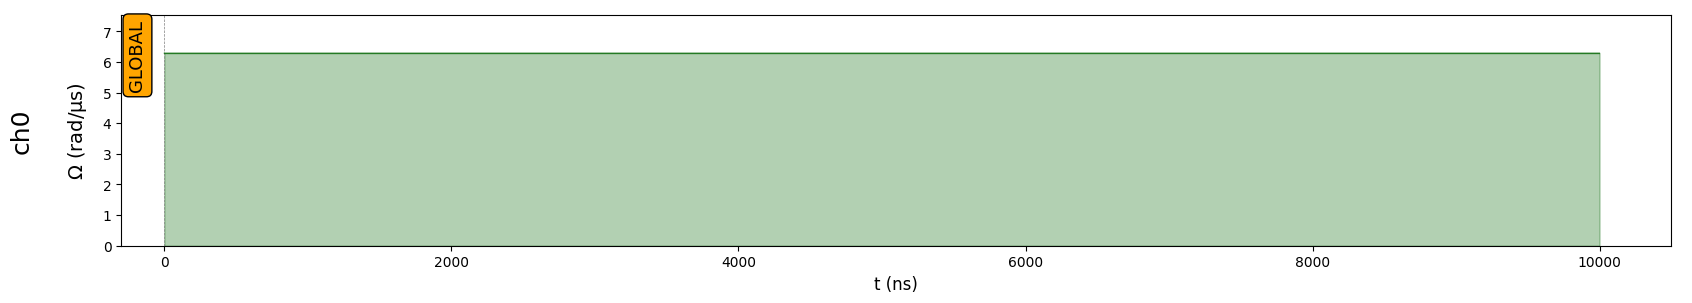

In [3]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ch0", "rydberg_global")
duration = 10000
pulse = Pulse.ConstantPulse(duration, 2 * np.pi, 0 * np.pi, 0.0)
seq.add(pulse, "ch0")
seq.draw()

The corresponding hamiltonian is $\mathcal{H}(t) = \frac{\hbar \Omega(t)}{2}\sigma^x$

We now run the noiseless simulation

In [4]:
clean_simu = Simulation(seq, sampling_rate=0.05)
clean_res = clean_simu.run()

We can observe the population on the ground state using it's projector

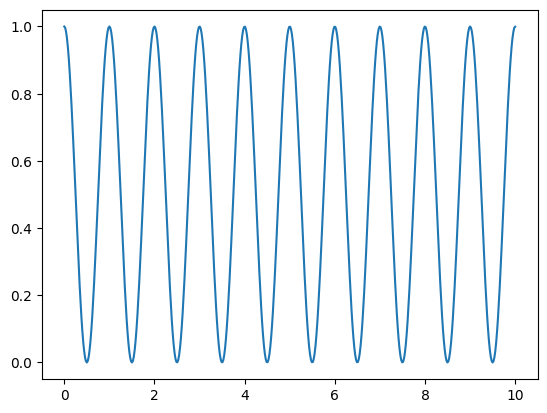

In [5]:
obs = qutip.basis(2, 1).proj()
plt.plot(clean_res._sim_times, clean_res.expect([obs])[0])
plt.show()

The are two ways to define the dephasing channel on pulser.

The first way is by creating a `SimConfig` object, specifying you want the dephasing noise and choosing the *dephasing probability*

In [6]:
config_dephasing = SimConfig(noise="dephasing", dephasing_prob=0.1)
clean_simu.set_config(config_dephasing)
clean_simu.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5
Noise types:           dephasing
Dephasing probability: 0.1


The second way, which is a more general way, allows not only to describe the dephasing noise, but also all effective noise channels.

In [7]:
clean_simu.reset_config()
config_dephasing = SimConfig(
    noise="eff_noise",
    eff_noise_opers=[qutip.qeye(2), qutip.sigmaz()],
    eff_noise_probs=[1 - 0.05, 0.05],
)
clean_simu.add_config(config_dephasing)
clean_simu.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5
Noise types:           eff_noise
Effective noise distribution:       [0.95, 0.05]
Effective noise operators:       [Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]]


Then we clean the simulation for future usage

In [8]:
clean_simu.reset_config()
clean_simu.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5


This is more explicit than the first method since we see the operators corresponding to the effective noise channel. In the case of the *dephasing channel*, the operators are: $\mathbb{I}$ and $\sigma_z$, which is what we see at the right of `Effective noise operators`.

Let us now simulate the entire sequence with the dephasing noise. We should see damped oscillations whenever the dephasing probability is non zero.

We define some useful functions for our simulations.

In [10]:
def get_population(rho, psi_0):
    """
    Expectation value of the input density matrix over a given direction psi_0
    """
    return psi_0.dag() * rho * psi_0


def noise_channel(density_matrix, collapse_op):
    """
    Apply the underlying superoperator of a noise channel to an input density matrix
    """
    # We represent the superoperator using the Kraus representation
    output = 0 * density_matrix
    for c_op in collapse_op:
        output += c_op * density_matrix * c_op.dag()
    return output


def get_population_evolution(result: SimulationResults, state):
    """
    Evolution of the expectation value of the density matrix along a state over time
    """
    population = []
    for rho_t in result.states:
        population.append(get_population(rho_t, state)[0][0])
    return population


def noisy_dynamics(clean_simu: Simulation, config: SimConfig):
    """
    Noisy simulation and metrics
    """
    simu = deepcopy(clean_simu)
    # Adding noise
    simu.add_config(config)
    result = simu.run()
    return simu, result

Then we run our simulations

In [11]:
dephasing_probabilities = np.linspace(0, 1, 5)
noisy_results = []
n_gaps = []
for dephasing_probability in dephasing_probabilities:
    print("Dephasing probability = ", dephasing_probability)

    # Configure the dephasing noise and run simulation
    config = SimConfig(noise="dephasing", dephasing_prob=dephasing_probability)
    simu, noisy_result = noisy_dynamics(clean_simu, config)
    print(len(simu._collapse_ops), simu._size, len(simu._qid_index))
    # Gap from the no noise config
    n_gap = []
    for i in range(len(noisy_result.states)):
        n_gap.append(
            qutip.tracedist(clean_res.states[i], noisy_result.states[i])
        )

    # Storage
    noisy_results.append(noisy_result)
    n_gaps.append(n_gap)

Dephasing probability =  0.0
2 1 1
Dephasing probability =  0.25
2 1 1
Dephasing probability =  0.5
2 1 1
Dephasing probability =  0.75
2 1 1
Dephasing probability =  1.0
2 1 1


#### Population evolution

/home/varda/.virtualenvs/pulser/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


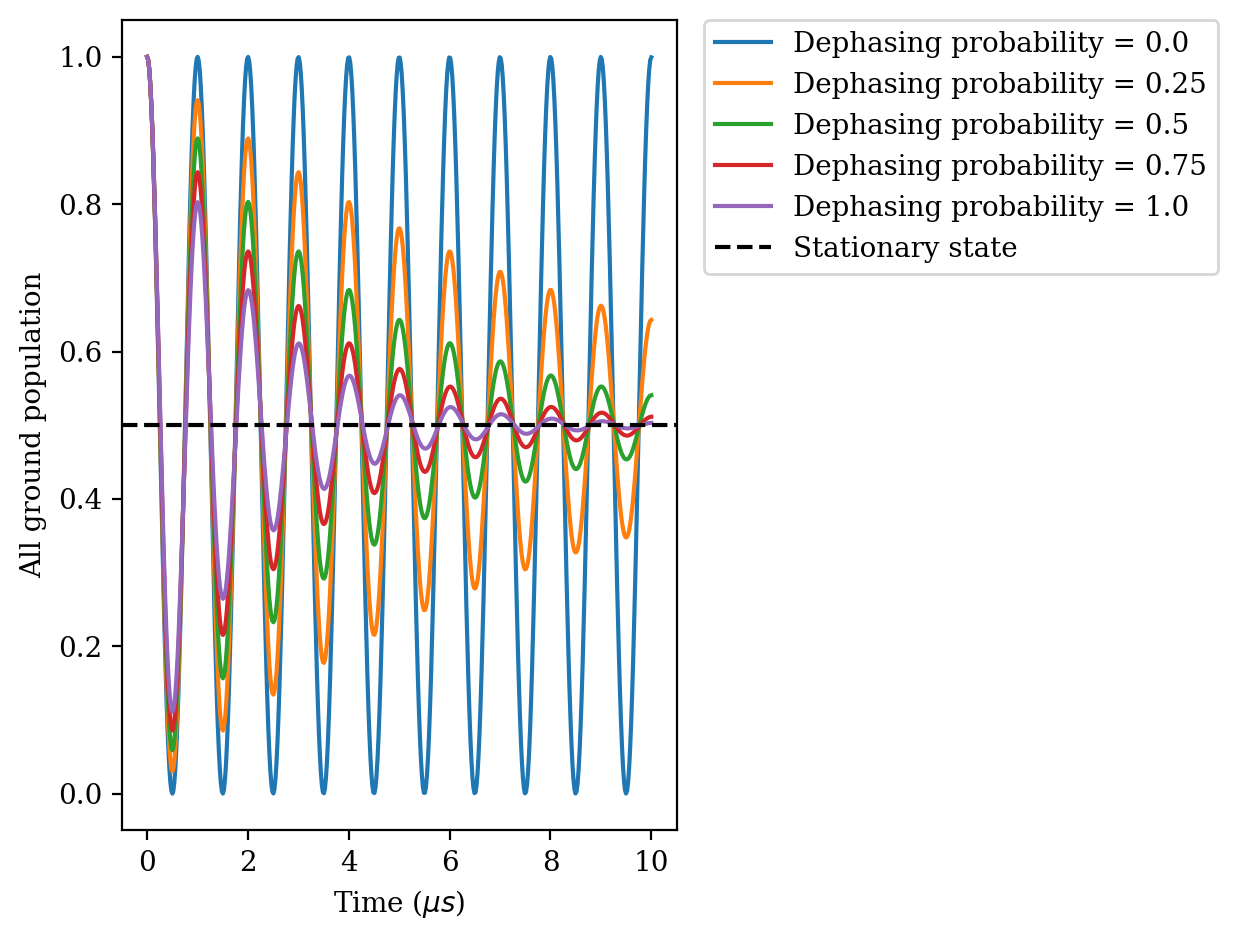

In [12]:
# Ground state population with noise
psi_0 = clean_simu.initial_state
noisy_pops = [
    get_population_evolution(noisy_result, state=psi_0)
    for noisy_result in noisy_results
]
times = noisy_results[0]._sim_times

plt.rc("font", family="serif")
plt.rc("figure", dpi=200)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("All ground population")

for dephasing_probability, noisy_pop in zip(
    dephasing_probabilities, noisy_pops
):
    plt.plot(
        times,
        noisy_pop,
        label=f"Dephasing probability = {dephasing_probability}",
    )
plt.axhline(0.5, color="black", linestyle="--", label="Stationary state")

# put labels outside of the plot:
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.tight_layout()

When we look at how the population at the ground state evolves, we notice that they also goes to the high dephasing area, and the speed of converge increases with the dephasing probability $p$. The more $p$ is high, the higher the attenuation, the dephasing effects will be noticed.

Let's now take a look to the distance from the mixed state to have more insight

#### Trace distance

Let's look to the gap between $\rho_{noise}$ and $\rho_{clean}$ in different dephasing configuration.

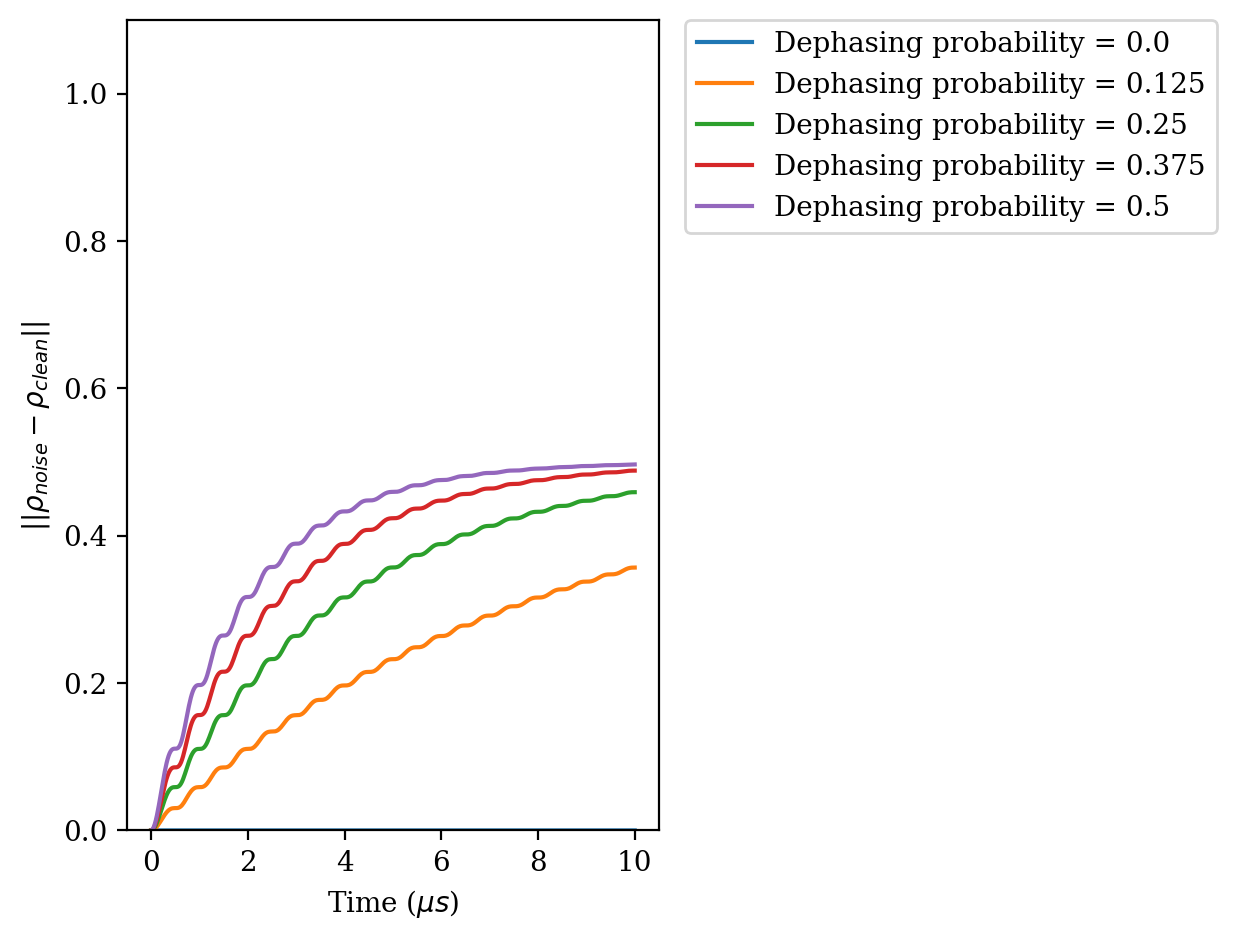

In [13]:
for dephasing_probability, dist in zip(dephasing_probabilities, n_gaps):
    plt.plot(
        times, dist, label=f"Dephasing probability = {dephasing_probability/2}"
    )
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$|| \rho_{noise} - \rho_{clean} || $")
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.tight_layout()

The divergence from the clean density matrix is higher than $0.2$ even for low probabilities. Which is good for us in the multi-qubit case and we will see later why.

### Antiferromagnetic state preparation

We would like to analyse the dephasing noise effect in the antiferromagnetic state preparation. We already how the dephasing noise acts on a single qubit, now we are interested on the many body case.

The pulse and the register are defined by the following parameters

In [81]:
# Parameters in rad/µs and ns
Omega_max = 2.3 * 2 * np.pi
U = Omega_max / 2.3

delta_0 = -6 * U
delta_f = 2 * U

t_rise = 252
t_fall = 500
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000

R_interatomic = Chadoq2.rydberg_blockade_radius(U)

We set up our register

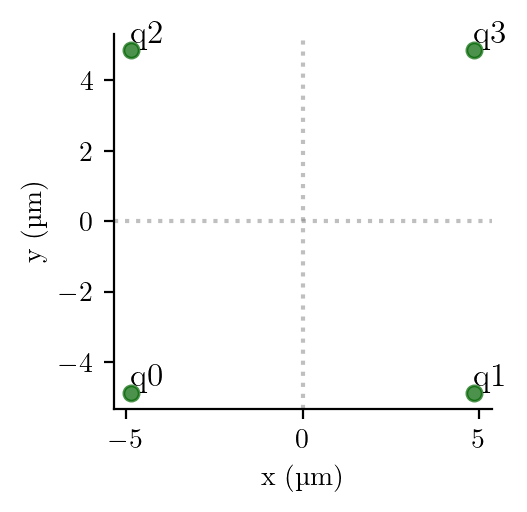

In [114]:
N_side = 2

reg = Register.square(N_side, R_interatomic, prefix="q")
reg.draw()

Now we build the sequence

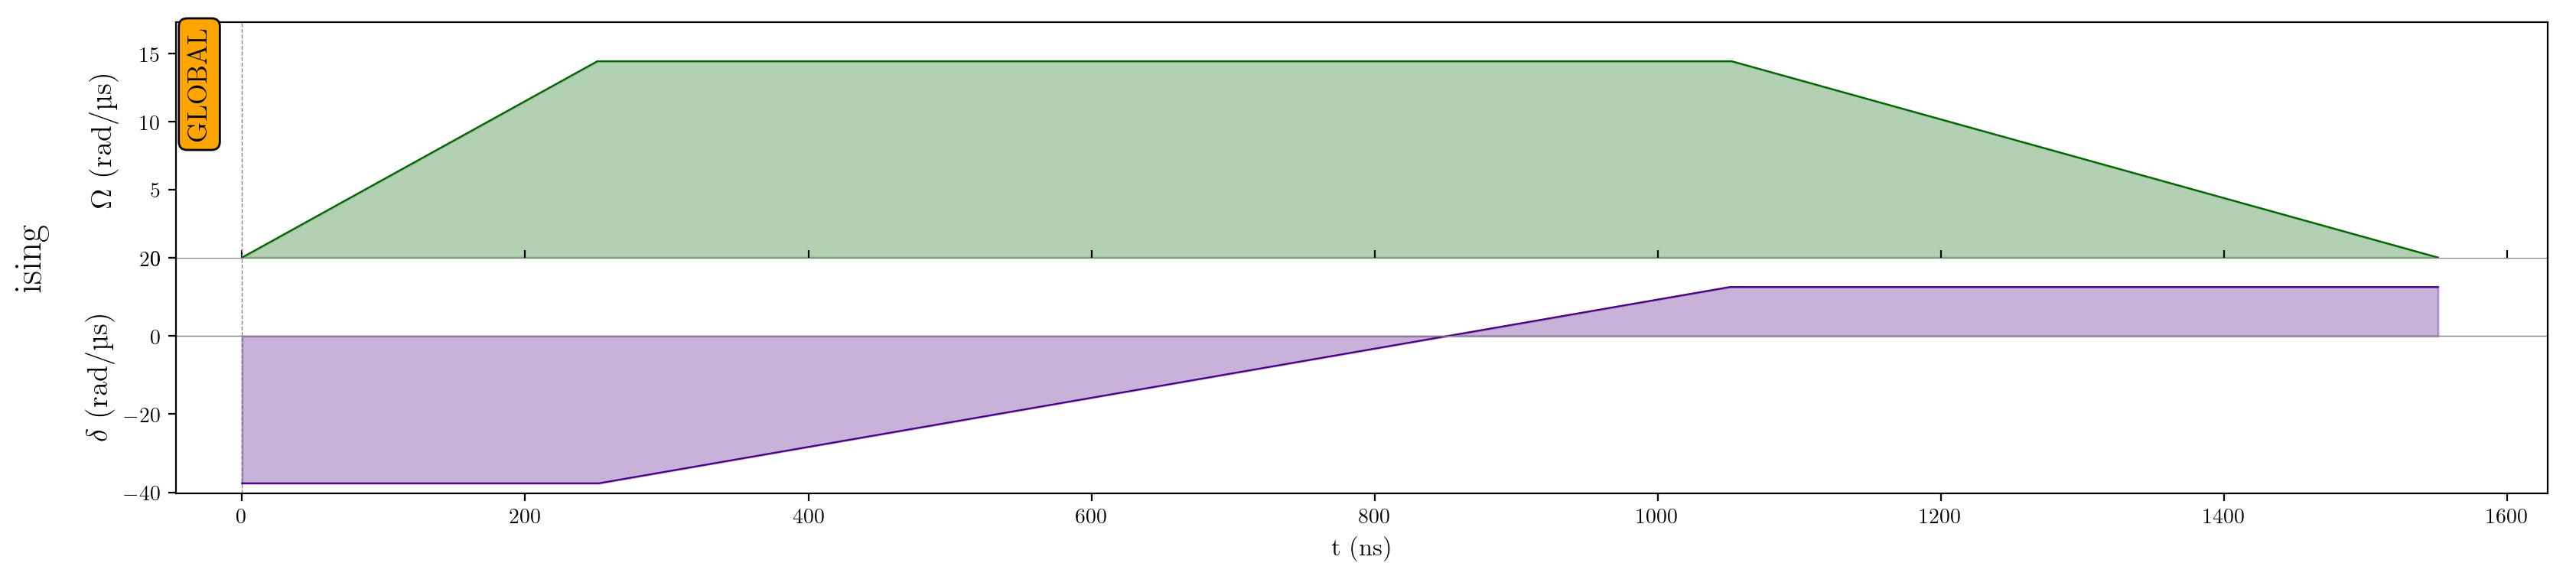

In [115]:
rise = Pulse.ConstantDetuning(
    RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0
)
sweep = Pulse.ConstantAmplitude(
    Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.0
)
fall = Pulse.ConstantDetuning(
    RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0
)

seq = Sequence(reg, Chadoq2)
seq.declare_channel("ising", "rydberg_global")

seq.add(rise, "ising")
seq.add(sweep, "ising")
seq.add(fall, "ising")

seq.draw()

Let's see first what happen without any noise

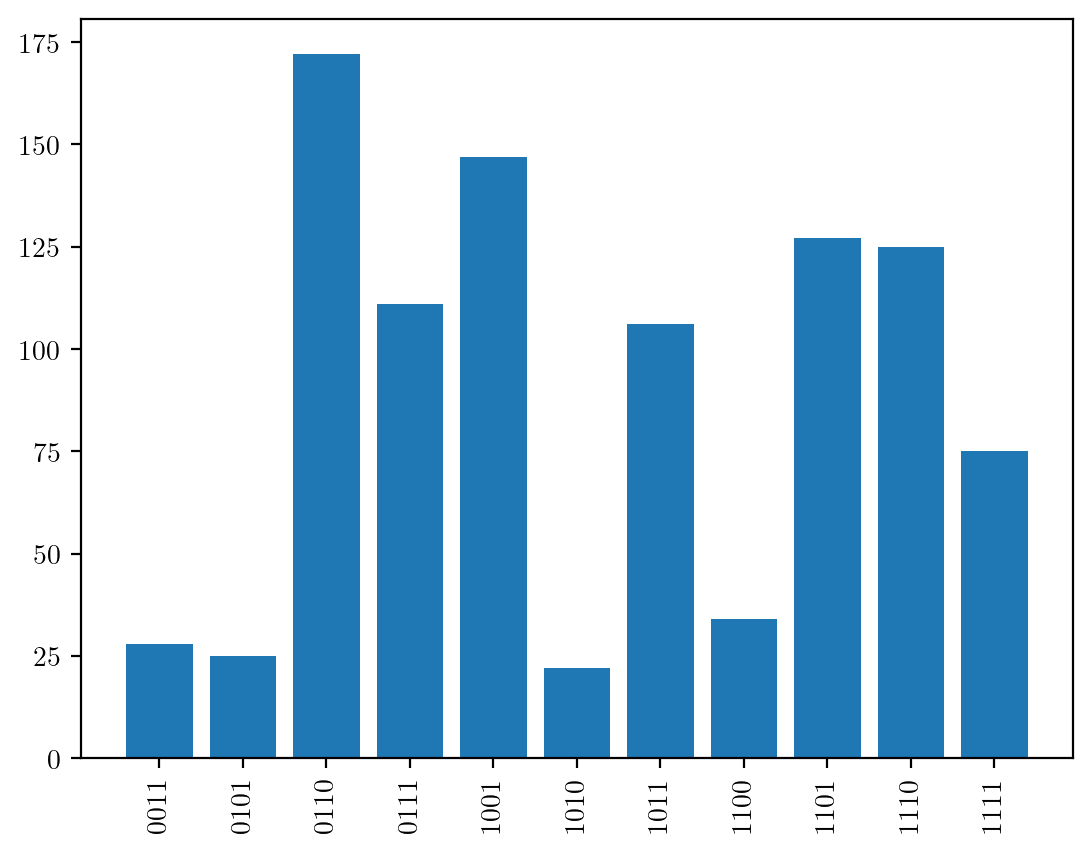

In [116]:
clean_simu = Simulation(seq, sampling_rate=0.05)
clean_results = clean_simu.run()
count = clean_results.sample_final_state()

most_freq = {k: v for k, v in count.items() if v > 10}
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.show()

In [117]:
clean_simu.initial_state.shape

(16, 1)

In [109]:
# Ferromagnetic state
N_qubits = len(reg._ids)
all_ground = [qutip.basis(2, 1)] * (N_qubits)
AFM_state = all_ground
for i in range(1, N_qubits, 2):
    AFM_state[i] = qutip.basis(2, 0)
AFM_state = qutip.tensor(AFM_state)

In [110]:
# How does the population evolve along the ferromagntic state
times = clean_results._sim_times
AFM_pop = get_population_evolution(clean_results, state=AFM_state)

/home/varda/.virtualenvs/pulser/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


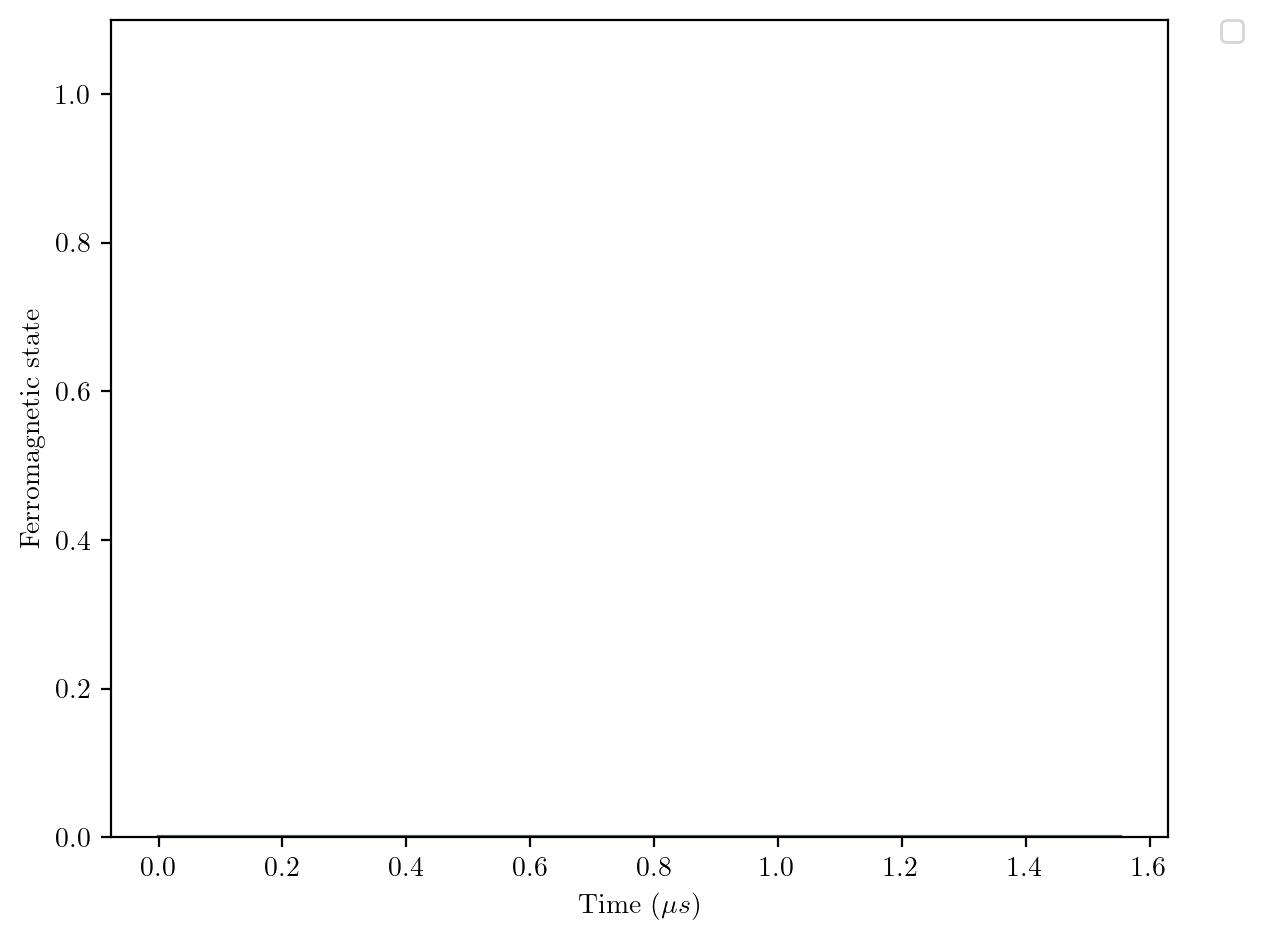

In [111]:
plt.plot(times, AFM_pop)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("Ferromagnetic state")
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.tight_layout()

Why do we see nothing? So the expectation value at each step is zero?

Let's put some noise in the game.

The dephasing channel we implemented for many body systems is valid if and only if the dephasing probability is low enough. What we called the uncorrelated noise approximation.

Basically, to be able to write easily the collapse operator of the dephasing channel for a many body system, we assume that one bit a the time is modified. And to make it happen, the dephasing probability $p$ needs to be low so that $p^n\simeq0$, where n is the number of qubits.

For now we didn't prevent the user to simulate the dephasing channel where p is "large"($p>0.1$). But we put a warning to alert the user that the domain in which he is working is out the approximation used which can make the results difficult to interpret.

In [112]:
dephasing_probabilitys = np.linspace(0, 0.2, 5)

In [113]:
noisy_results = []
noisy_pops = []
n_gaps = []
AFM_pops = []

for dephasing_probability in dephasing_probabilitys:
    print("Dephasing probability = ", dephasing_probability / 2)
    # Configure the dephasing noise
    config = SimConfig(
        noise="eff_noise",
        eff_noise_opers=[qutip.qeye(2), qutip.sigmaz()],
        eff_noise_probs=[
            1 - dephasing_probability / 2,
            dephasing_probability / 2,
        ],
    )
    simu, noisy_result = noisy_dynamics(
        clean_simu, config, dephasing_probability
    )

    # Compute the mixed_state expectation value
    rho = noisy_result.states[0]
    psi_0 = simu.initial_state

    # Ground state population evolution and distance from the mixed state
    noisy_pop = get_population_evolution(noisy_result, state=psi_0)

    # Gap from the no noise situation
    n_gap = []
    for i in range(len(noisy_result.states)):
        n_gap.append(
            qutip.tracedist(clean_results.states[i], noisy_result.states[i])
        )
    AFM_pop = get_population_evolution(noisy_result, state=AFM_state)

    # Storage
    noisy_results.append(noisy_result)
    noisy_pops.append(noisy_pop)
    n_gaps.append(n_gap)
    AFM_pops.append(AFM_pop)

Dephasing probability =  0.0
Dephasing probability =  0.025


KeyboardInterrupt: 

Let's see how the ground state population evolves accross time

/home/varda/.virtualenvs/pulser/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


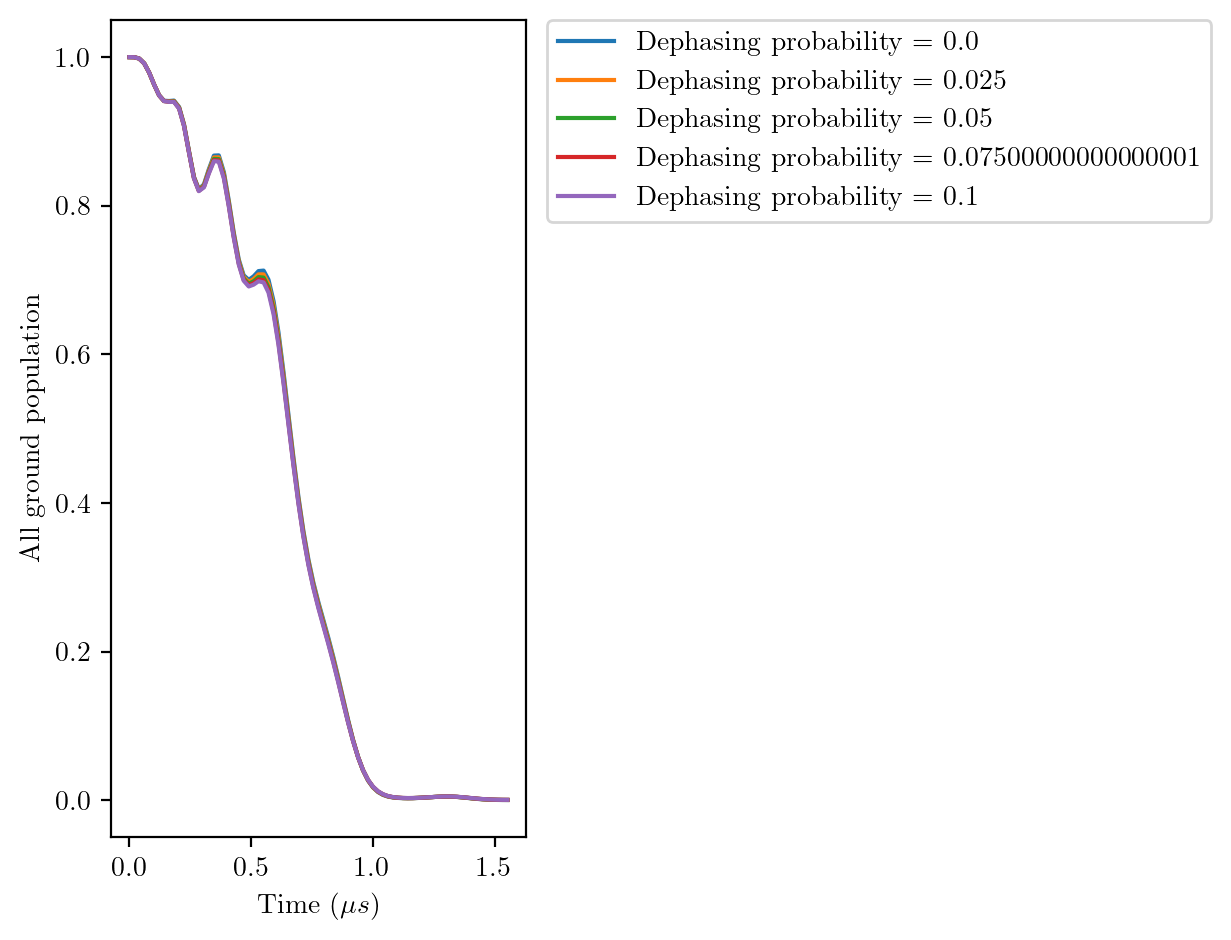

In [ ]:
times = noisy_results[1]._sim_times
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
plt.rc("figure", dpi=200)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("All ground population")
for dephasing_probability, noisy_pop in zip(
    dephasing_probabilitys, noisy_pops
):
    plt.plot(
        times,
        noisy_pop,
        label=f"Dephasing probability = {dephasing_probability/2}",
    )

# put labels outside of the plot:
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.tight_layout()

There is no observed significant effect of the dephasing noise on the ground state population, how about the distance between density matrices?

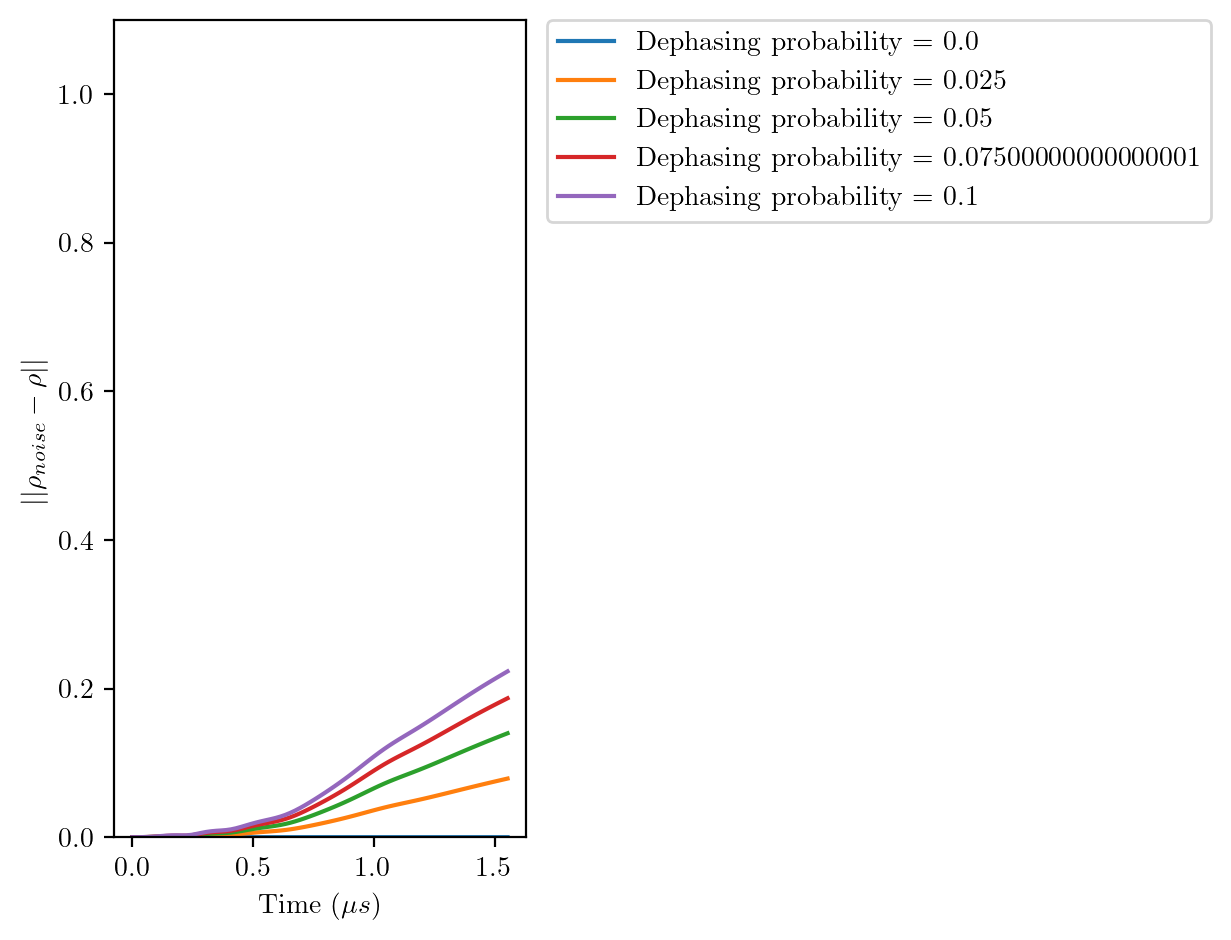

In [ ]:
for dephasing_probability, dist in zip(dephasing_probabilitys, n_gaps):
    plt.plot(
        times, dist, label=f"Dephasing probability = {dephasing_probability/2}"
    )
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"$|| \rho_{noise} - \rho || $")
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.tight_layout()

Unlike the evolution of the ground-state population, we can notice a clear divergence from the clean result which increases with p. But is the state preparation spoiled or not?

#### Evolution of the population in the ferromagnetic basis

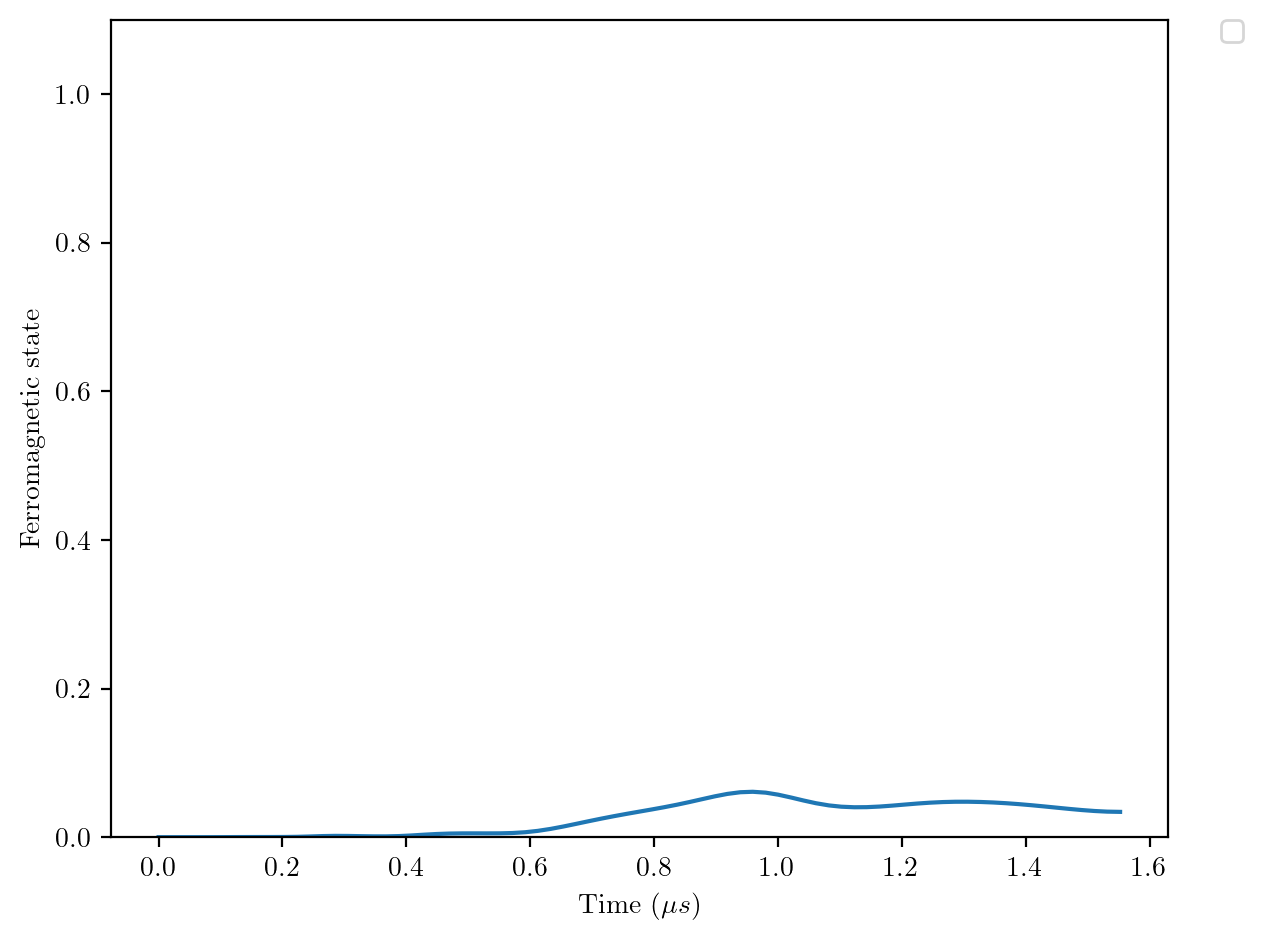

In [ ]:
plt.plot(times, AFM_pop)
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("Ferromagnetic state")
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.tight_layout()

We still have no plots at all, meaning the expectation value along the ferromagnetic state is always zero. Is it normal?

Let's sample to see what is the most dominant state

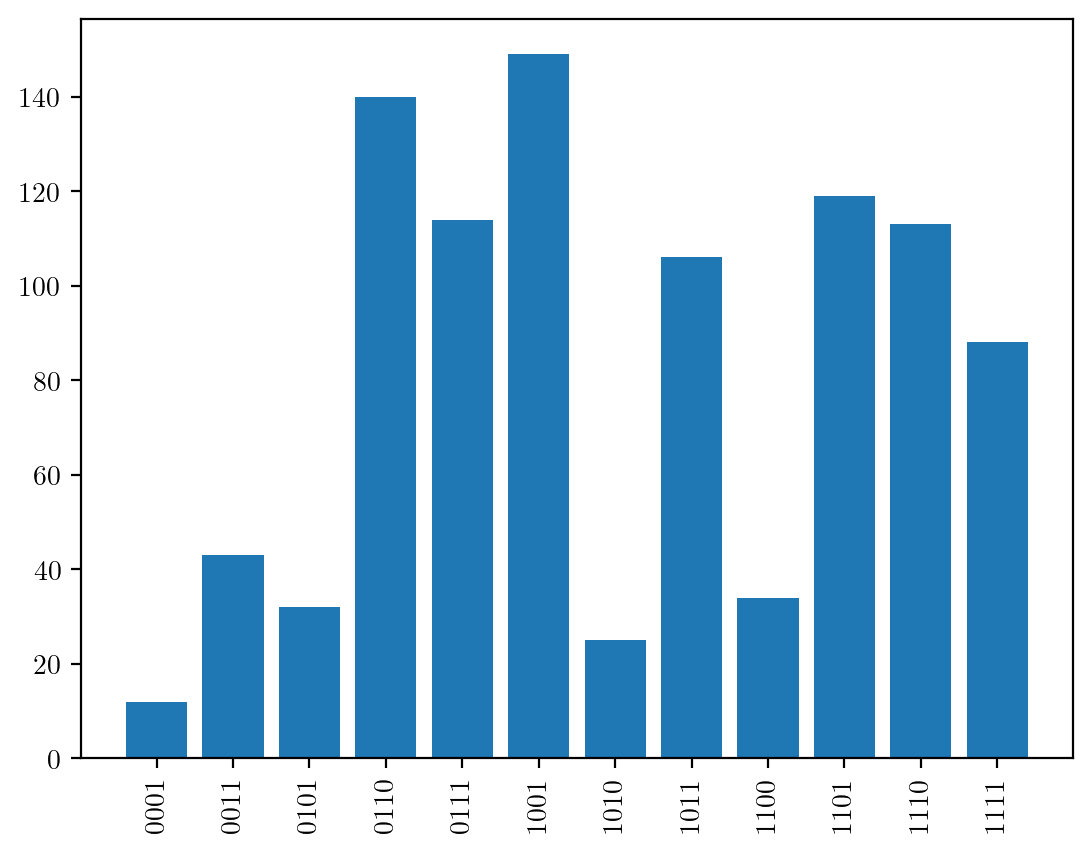

In [ ]:
count = noisy_results[-1].sample_final_state()

most_freq = {k: v for k, v in count.items() if v > 10}
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.show()